In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import string
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
nltk.download('punkt')
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\hp\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
data = pd.read_csv('spam.csv', encoding='latin')
data.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [3]:
data.shape

(5572, 5)

# Project Steps
1) Data Cleaning
2) EDA
3) Text Preprocessing
4) Model Building
5) Evaluation
6) Improvement

## 1. Data Cleaning

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   v1          5572 non-null   object
 1   v2          5572 non-null   object
 2   Unnamed: 2  50 non-null     object
 3   Unnamed: 3  12 non-null     object
 4   Unnamed: 4  6 non-null      object
dtypes: object(5)
memory usage: 217.8+ KB


In [5]:
# Drop unnecessary columns
data = data.drop(columns=['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'])

In [6]:
data.head()

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [7]:
# Change Column Names
data.rename(columns={'v1': 'target', 'v2': 'text'}, inplace=True)
data.head()

,target,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [8]:
# Label Encoding
# ham = 0
# spam = 1

from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
data['target'] = encoder.fit_transform(data['target'])

In [9]:
data.head()

,target,text
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


In [10]:
# Missing Values
data.isnull().sum()

target    0
text      0
dtype: int64

In [11]:
# Check for Duplicated Values if found Drop them
data.duplicated().sum()

403

In [12]:
data = data.drop_duplicates(keep='first')

In [13]:
data.duplicated().sum()

0

## 2. EDA

In [14]:
data.head()

,target,text
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


In [15]:
data['target'].value_counts()

0    4516
1     653
Name: target, dtype: int64

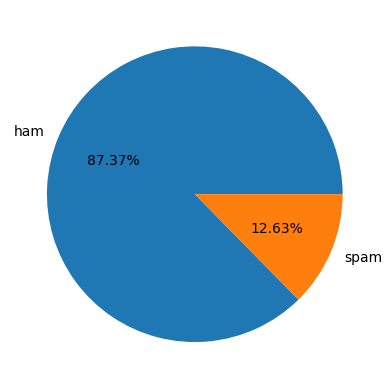

In [16]:
plt.pie(data['target'].value_counts(), labels=['ham','spam'], autopct='%0.2f%%') 
plt.show()

#### Here we can conclude that data is imbalanced

In [17]:
data['characters'] = data['text'].apply(len)

In [18]:
data['words'] = data['text'].apply(lambda x:len(nltk.word_tokenize(x)))

In [19]:
data['sentences'] = data['text'].apply(lambda x:len(nltk.sent_tokenize(x)))

In [20]:
data.head()

,target,text,characters,words,sentences
0,0,"Go until jurong point, crazy.. Available only ...",111,24,2
1,0,Ok lar... Joking wif u oni...,29,8,2
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155,37,2
3,0,U dun say so early hor... U c already then say...,49,13,1
4,0,"Nah I don't think he goes to usf, he lives aro...",61,15,1


In [21]:
# ham and spam describe
# ham

data[data['target'] == 0][['characters','words','sentences']].describe()

,characters,words,sentences
count,4516.000000,4516.000000,4516.000000
mean,70.459256,17.123782,1.820195
std,56.358207,13.493970,1.383657
min,2.000000,1.000000,1.000000
25%,34.000000,8.000000,1.000000
50%,52.000000,13.000000,1.000000
75%,90.000000,22.000000,2.000000
max,910.000000,220.000000,38.000000


In [22]:
# spam
data[data['target'] == 1][['characters','words','sentences']].describe()

,characters,words,sentences
count,653.000000,653.000000,653.000000
mean,137.891271,27.667688,2.970904
std,30.137753,7.008418,1.488425
min,13.000000,2.000000,1.000000
25%,132.000000,25.000000,2.000000
50%,149.000000,29.000000,3.000000
75%,157.000000,32.000000,4.000000
max,224.000000,46.000000,9.000000


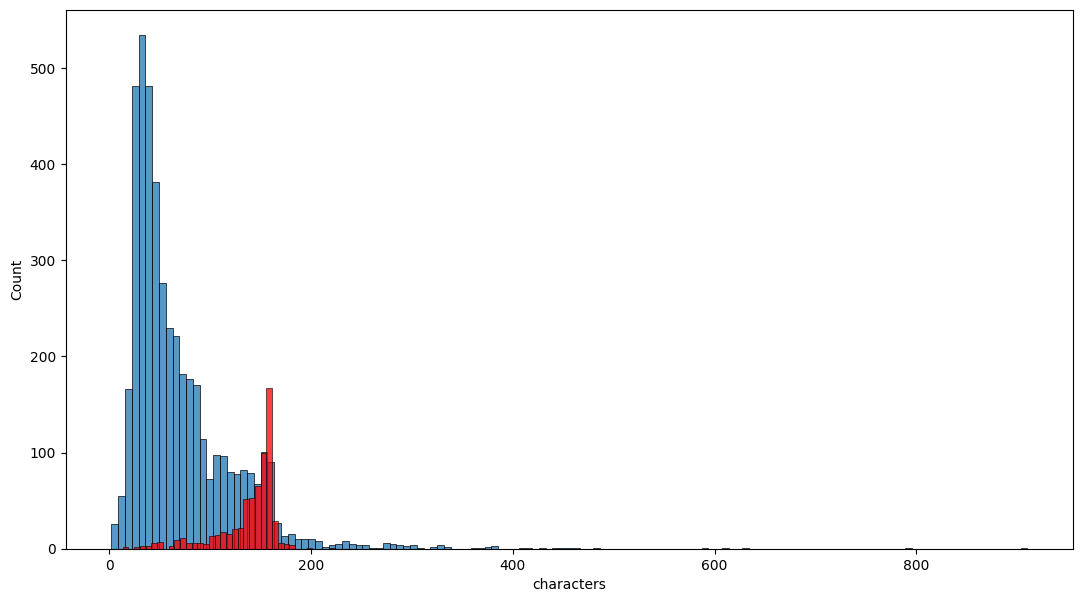

In [23]:
plt.figure(figsize=(13,7))
sns.histplot(data[data['target'] == 0]['characters'])
sns.histplot(data[data['target'] == 1]['characters'],color = 'red')
plt.show()

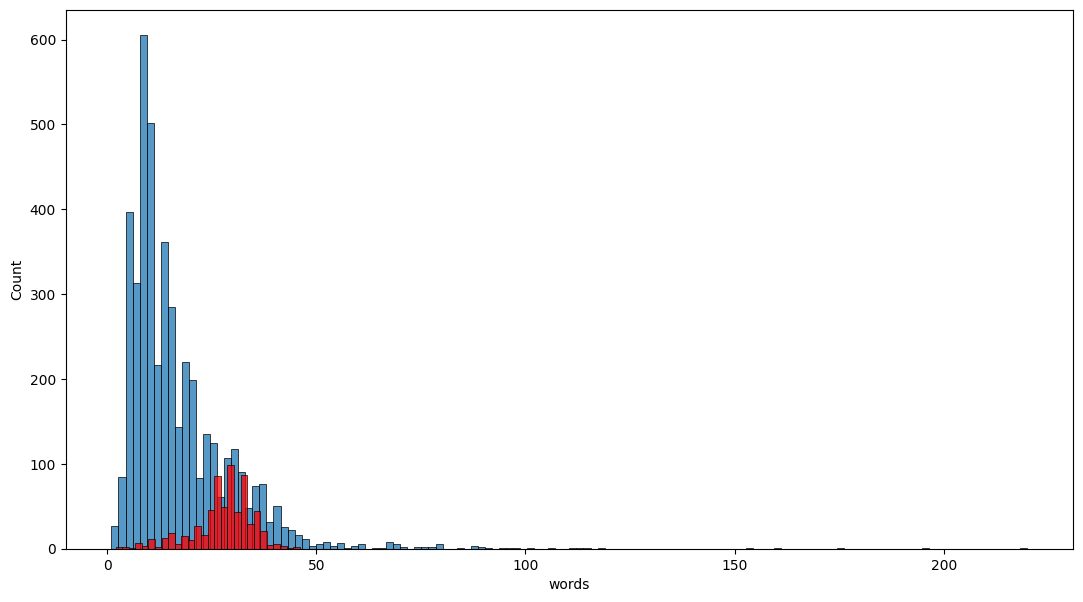

In [24]:
plt.figure(figsize=(13,7))
sns.histplot(data[data['target'] == 0]['words'])
sns.histplot(data[data['target'] == 1]['words'],color = 'red')
plt.show()

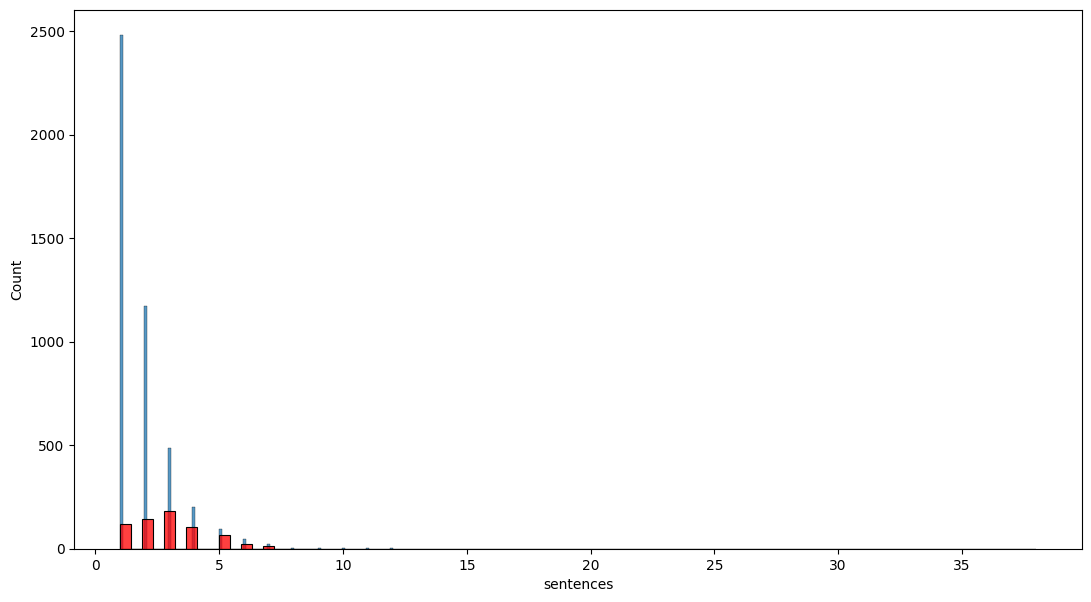

In [25]:
plt.figure(figsize=(13,7))
sns.histplot(data[data['target'] == 0]['sentences'])
sns.histplot(data[data['target'] == 1]['sentences'],color = 'red')
plt.show()

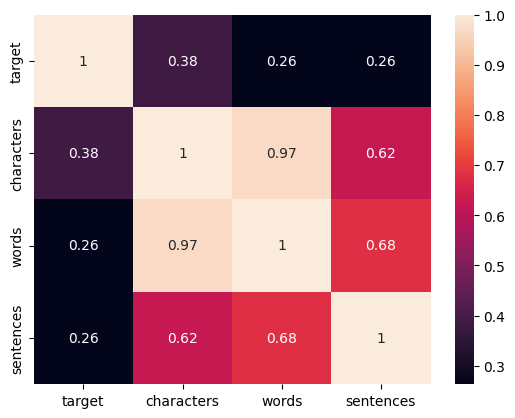

In [26]:
sns.heatmap(data.corr(),annot=True)
plt.show()

#  3. Text preprocessing
* lower case
* tokenization
* removing special characters
* removing stop words and punctuation
* stemming

In [27]:
ps = PorterStemmer()

In [28]:
def transform_text(text):
    text = text.lower()
    text = nltk.word_tokenize(text)
    
    y = []
    for i in text:
        if i.isalnum():
            y.append(i)
    
    text = y[:]
    y.clear()
    
    for i in text:
        if i not in stopwords.words('english') and i not in string.punctuation:
            y.append(i)
            
            
    text = y[:]
    y.clear()
    
    for i in text:
        y.append(ps.stem(i))
    
    return " ".join(y)

In [29]:
transform_text('HI HOW ARE YOU LOVE!!!!!!!')

'hi love'

In [30]:
data['transformed_text'] = data['text'].apply(transform_text)

In [31]:
wc = WordCloud(width=1000, height=1000, min_font_size=10, background_color='black')

In [32]:
spam_wc = wc.generate(data[data['target'] == 1]['transformed_text'].str.cat(sep=" "))

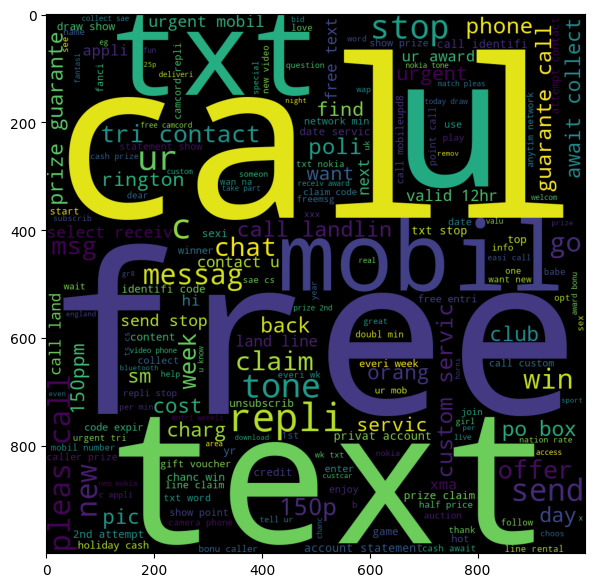

In [33]:
plt.figure(figsize=(15,7))
plt.imshow(spam_wc)

In [34]:
ham_wc = wc.generate(data[data['target'] == 0]['transformed_text'].str.cat(sep=" "))

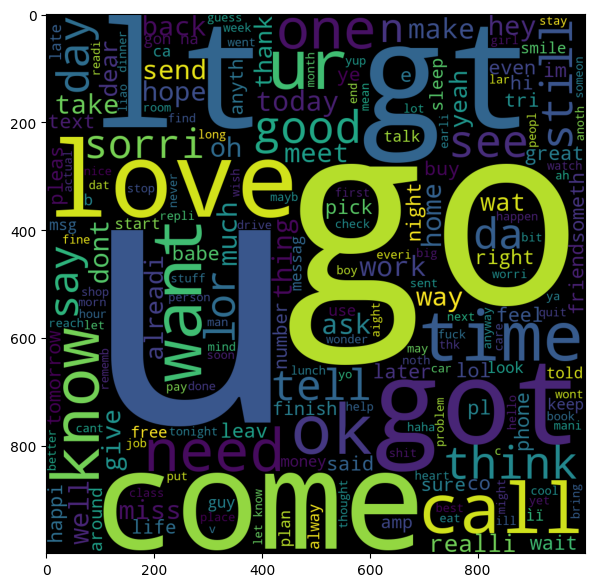

In [35]:
plt.figure(figsize=(15,7))
plt.imshow(ham_wc)

In [36]:
spam_corpus = []
for msg in data[data['target'] == 1]['transformed_text'].tolist():
    for word in msg.split():
        spam_corpus.append(word)

In [37]:
word_counts = Counter(spam_corpus)

top_words_df = pd.DataFrame(word_counts.most_common(30), columns=['Word', 'Frequency'])

plt.figure(figsize=(12, 6))
sns.barplot(data=top_words_df, x='Word', y='Frequency')
plt.xticks(rotation=90)
plt.xlabel('Word')
plt.ylabel('Frequency')
plt.title('Top 30 Most Common Words in Spam Corpus')
plt.show()

NameError: name 'Counter' is not defined

In [ ]:
ham_corpus = []
for msg in data[data['target'] == 0]['transformed_text'].tolist():
    for word in msg.split():
        ham_corpus.append(word)

In [ ]:
word_counts = Counter(ham_corpus)

top_words_df = pd.DataFrame(word_counts.most_common(30), columns=['Word', 'Frequency'])

plt.figure(figsize=(12, 6))
sns.barplot(data=top_words_df, x='Word', y='Frequency')
plt.xticks(rotation=90)
plt.xlabel('Word')
plt.ylabel('Frequency')
plt.title('Top 30 Most Common Words in Ham Corpus')
plt.show()

# 4. Model Building

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
cv = CountVectorizer()
tfidf = TfidfVectorizer()

In [ ]:
# X = cv.fit_transform(data['transformed_text']).toarray()
X = tfidf.fit_transform(data['transformed_text']).toarray()

In [ ]:
y = data['target'].values

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=2)

In [ ]:
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score

In [ ]:
gnb = GaussianNB()
mnb = MultinomialNB()
bnb = BernoulliNB()

In [ ]:
gnb.fit(X_train,y_train)
y_pred1 = gnb.predict(X_test)
print('Accuracy Score:', accuracy_score(y_test,y_pred1))
print('Confusion Matrix:\n', confusion_matrix(y_test,y_pred1))
print('Precision Score:', precision_score(y_test,y_pred1))
print('--------------------------------------------------------')

mnb.fit(X_train,y_train)
y_pred2 = mnb.predict(X_test)
print('Accuracy Score:', accuracy_score(y_test,y_pred2))
print('Confusion Matrix:\n', confusion_matrix(y_test,y_pred2))
print('Precision Score:', precision_score(y_test,y_pred2))
print('--------------------------------------------------------')

bnb.fit(X_train,y_train)
y_pred3 = bnb.predict(X_test)
print('Accuracy Score:', accuracy_score(y_test,y_pred3))
print('Confusion Matrix:\n', confusion_matrix(y_test,y_pred3))
print('Precision Score:', precision_score(y_test,y_pred3))
print('--------------------------------------------------------')

# Thank You!